# Feature Engineering

### Topic 1: Consistency Index

In [1]:
import pandas as pd
df = pd.read_csv('Data/integrated_match_player_sample.csv')
df.head(5)
player_stats = df.groupby('player')['runs'].agg(['mean','std','count']).reset_index()
player_stats = player_stats.rename(columns={'mean':'mean_runs','std':'std_runs','count':'innings'})
# handle zero std (player with single inning or identical scores)
player_stats['std_runs'] = player_stats['std_runs'].fillna(0)
player_stats['consistency_index'] = player_stats.apply(
    lambda row : row['mean_runs']/row['std_runs'] if row['std_runs'] > 0 else row['mean_runs'],
    axis = 1
    )
player_stats.sort_values('consistency_index',ascending= False).head(10)






,player,mean_runs,std_runs,innings,consistency_index
3,Faf du Plessis,35.000000,3.464102,3,10.103630
12,Rohit Sharma,37.000000,5.567764,3,6.645396
1,Andre Russell,26.000000,3.915780,4,6.639801
17,Virat Kohli,44.666667,7.571878,3,5.899021
11,Rishabh Pant,12.500000,2.121320,2,5.892557
0,Abdul Samad,52.750000,13.301002,4,3.965866
13,Ruturaj Gaikwad,23.000000,6.271629,4,3.667309
9,Prithvi Shaw,28.500000,7.778175,2,3.664099
5,Hardik Pandya,30.000000,8.717798,3,3.441236
16,Suryakumar Yadav,49.333333,16.502525,3,2.989442


### Topic 2: Aggression Index

              player  aggression_index
0        Virat Kohli        698.275000
1    Ravindra Jadeja        576.198790
2        Abdul Samad        285.902394
3   Suryakumar Yadav        281.432258
4    Kane Williamson         78.122687
5           MS Dhoni         63.961305
6  Bhuvneshwar Kumar         48.776583
7       Rishabh Pant         46.631818
8       Shubman Gill         44.999500
9       Sunil Narine         43.444145


/var/folders/rx/bfj9nybj02jf94xlvrjnp9nr0000gn/T/ipykernel_2412/3314475877.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='aggression_index', y='player', data=top10_aggressive, palette='coolwarm')


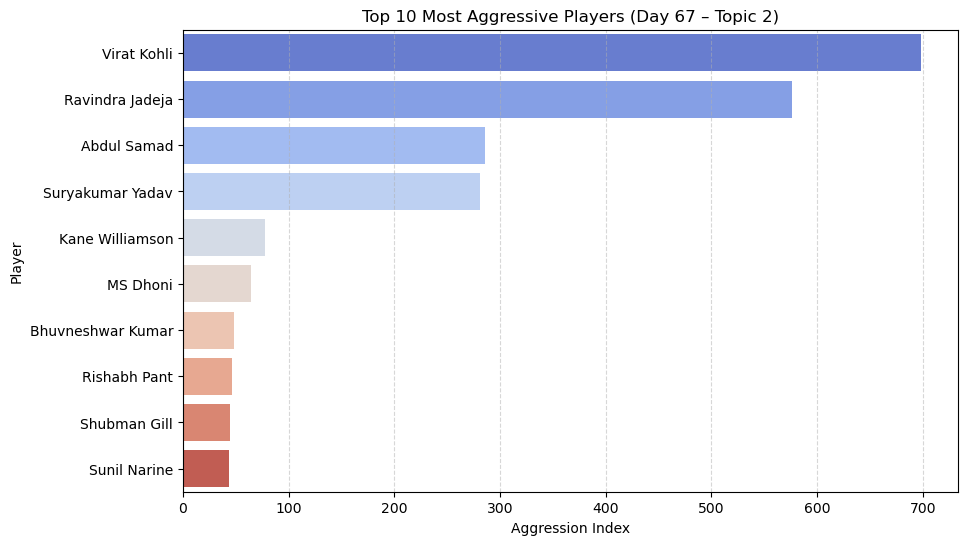

In [19]:
# Step 1: Calculate Boundary Runs and Boundary %
df.head(5)
df['Boundry_runs'] = (df['fours'] * 4 + df['sixes'] * 6)
df['Boundry_percent'] = (df['Boundry_runs'] / df['runs']) * 100
df['Boundry_percent'] = df['Boundry_percent'].fillna(0)
df['aggression_index'] = df['strike_rate'] * df['Boundry_percent'] / 100
player_aggression = df.groupby('player')['aggression_index'].mean().sort_values(ascending = False).reset_index(name='aggression_index')
print(player_aggression.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# Sort and pick top 10 aggressive players
top10_aggressive = player_aggression.head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='aggression_index', y='player', data=top10_aggressive, palette='coolwarm')

plt.title('Top 10 Most Aggressive Players (Day 67 – Topic 2)')
plt.xlabel('Aggression Index')
plt.ylabel('Player')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


### Topic 3 (Form Feature) (Rolling Average of Last 5 Innings)

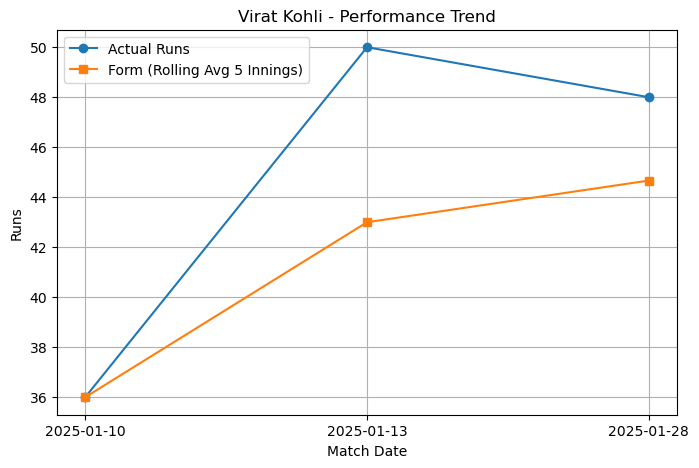

In [3]:
import pandas as pd

df = pd.read_csv("Data/integrated_match_player_sample.csv")

# Sort by player and match (to maintain chronological order)
df = df.sort_values(by=['player', 'date'])

# Create the 'form' feature using rolling average of last 5 innings
df['form'] = df.groupby('player')['runs'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

# Check first few rows
df[['player', 'match_id', 'date', 'runs', 'form']].head(15)

import matplotlib.pyplot as plt

player_name = 'Virat Kohli'  # change this name to test others

player_data = df[df['player'] == player_name]

plt.figure(figsize=(8,5))
plt.plot(player_data['date'], player_data['runs'], marker='o', label='Actual Runs')
plt.plot(player_data['date'], player_data['form'], marker='s', label='Form (Rolling Avg 5 Innings)')
plt.title(f'{player_name} - Performance Trend')
plt.xlabel('Match Date')
plt.ylabel('Runs')
plt.legend()
plt.grid(True)
plt.show()



### Topic 4: Encode Categorical Columns (Teams, Venue)

In [12]:
import pandas as pd
categorical_cols = ['team','venue']
df_encoded = pd.get_dummies(df,columns = categorical_cols,drop_first= True)
df_encoded.head(2)


,match_id,date,opponent,team_runs,winner,toss_winner,toss_decision,player,runs,balls,...,form,team_Delhi Capitals,team_Kolkata Knight Riders,team_Mumbai Indians,team_Royal Challengers Bangalore,team_Sunrisers Hyderabad,venue_Eden Gardens,venue_M. Chinnaswamy Stadium,venue_Rajiv Gandhi Stadium,venue_Wankhede Stadium
16,3,2025-01-07,Kolkata Knight Riders,156,Kolkata Knight Riders,Kolkata Knight Riders,field,Abdul Samad,64,13,...,64.0,False,False,False,False,True,False,True,False,False
19,4,2025-01-10,Royal Challengers Bangalore,175,Sunrisers Hyderabad,Royal Challengers Bangalore,bat,Abdul Samad,53,3,...,58.5,False,False,False,False,True,False,False,True,False


In [14]:
import pandas as pd

# Load your integrated dataset
df = pd.read_csv("Data/integrated_match_player_sample.csv")

# --- Feature 1: Consistency Index ---
player_consistency = df.groupby('player')['runs'].agg(['mean','std']).reset_index()
player_consistency['consistency_index'] = player_consistency.apply(
    lambda row: row['mean']/row['std'] if row['std']>0 else row['mean'], axis=1
)
df = df.merge(player_consistency[['player','consistency_index']], on='player', how='left')

# --- Feature 2: Aggression Index ---
df['boundary_runs'] = (df['fours']*4) + (df['sixes']*6)
df['boundary_percent'] = (df['boundary_runs'] / df['runs']).fillna(0) * 100
df['aggression_index'] = df['strike_rate'] * df['boundary_percent'] / 100

# --- Feature 3: Form Feature (Rolling Avg of Last 5 Innings) ---
df = df.sort_values(by=['player','date'])
df['form'] = df.groupby('player')['runs'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

# --- Feature 4: Encode Categorical Columns ---
categorical_cols = ['team', 'venue']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Save final dataset
df_encoded.to_csv("final_engineered_dataset_day67.csv", index=False)
print("✅ Final dataset saved as: final_engineered_dataset_day67.csv")


✅ Final dataset saved as: final_engineered_dataset_day67.csv
